# End-to-end: Power Analysis

We'll show the different functionalities of cluster_experiments, which are:
* MDE calculation
* MDE calculation in cluster-randomized experiments
* MDE calculation with simple covariate adjustment
* MDE calculation with cupac (adjustment via ML models)
* Inference for all the cases above


## Data generation

We create some pre-experimental data that we could use to run power analysis.

We have a dataframe with orders and customers, each customer may have many orders, and the two target metrics are delivery time and order value.



In [1]:
import random

import numpy as np
import pandas as pd
import seaborn as sns

from cluster_experiments import NormalPowerAnalysis

np.random.seed(42)
random.seed(42)

# Constants
N = 10000  # Number of orders
NUM_CUSTOMERS = 1000  # Unique customers

def generate_customers(num_customers):
    """Generate unique customers with a mean order value based on age."""
    customer_ids = np.arange(1, num_customers + 1)
    customer_ages = np.random.randint(20, 60, size=num_customers)
    mean_order_values = 50 + 0.8 * customer_ages + np.random.normal(0, 10, size=num_customers)

    return pd.DataFrame({
        "customer_id": customer_ids,
        "customer_age": customer_ages,
        "mean_order_value": mean_order_values
    })

def sample_orders(customers, num_orders):
    """Sample customers and generate order-level data."""
    sampled_customers = np.random.choice(customers["customer_id"], size=num_orders)
    return pd.DataFrame({"customer_id": sampled_customers}).merge(customers, on="customer_id", how="left")

def generate_orders(customers, num_orders):
    """Full order generation pipeline using .assign() for cleaner transformations."""
    date_range = pd.date_range(start="2024-01-01", end="2024-03-31")

    return (
        sample_orders(customers, num_orders)
        .assign(
            order_value=lambda df: df["mean_order_value"] + np.random.normal(0, 5, size=len(df)),
            delivery_time=lambda df: 8 + np.sin(df["customer_id"] / 10) + np.random.normal(0, 0.5, size=len(df)),
            city=lambda df: np.random.choice(["NYC", "LA"], size=len(df)),
            date=lambda df: np.random.choice(date_range, size=len(df))
        )
        .drop(columns=["mean_order_value"])  # Remove intermediate column
    )


def plot_mdes(mdes, x_lim=40, y_value=3):
    sns.lineplot(
        data=pd.DataFrame(mdes),
        x="experiment_length",
        y="mde",
    )

    sns.lineplot(
        x=[0, x_lim],
        y=[y_value, y_value],
        color="red",
        linestyle="--",
    )

def get_length(mdes, mde_value):
    return min(x["experiment_length"] for x in mdes if x["mde"] < mde_value)

def get_length_print(mdes, mde_value):
    length = get_length(mdes, mde_value)
    print(f"Minimum experiment length to detect MDE of {mde_value}: {length}")

# Run the pipeline
customers = generate_customers(NUM_CUSTOMERS)
experiment_data = generate_orders(customers, N)

print(experiment_data.head())


   customer_id  customer_age  order_value  delivery_time city       date
0          611            39    72.199186       7.495150  NYC 2024-01-28
1          704            23    81.011831       8.887809   LA 2024-03-31
2          243            52    89.979294       7.851989   LA 2024-03-22
3          831            23    65.235192       8.933512  NYC 2024-03-17
4          561            58    91.154383       6.976415   LA 2024-03-20


## Power analysis

### Order-level split

Assume we run an AB test randomizing at order level, in this case the dataset is at the order level, so we don't need cluster-randomized analysis, we just use regular splitter and analyse with ols. The following code shows the mde on order_value given some experiment length (1, 2, 3 and 4 weeks).

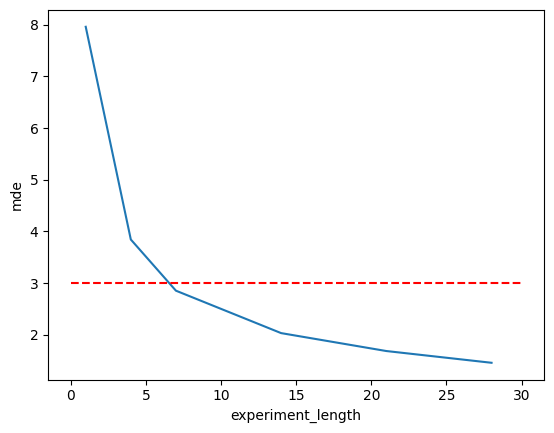

In [2]:
mde_order_split = NormalPowerAnalysis.from_dict({
    "splitter": "non_clustered",
    "analysis": "ols",
    "time_col": "date",
    "target_col": "order_value",
})

mdes = mde_order_split.mde_time_line(
    experiment_data,
    powers=[0.8],
    experiment_length=(1, 4, 7, 14, 21, 28),
    n_simulations=5
)

mde_value = 3

plot_mdes(mdes, y_value=mde_value, x_lim=30)

In [3]:
get_length_print(mdes, mde_value)

Minimum experiment length to detect MDE of 3: 7


### Customer-level split

Assume we randomize at customer level, in this case we need to use clustered_ols to run the power analysis. The following code shows the mde on order_value given some experiment length (1, 2, 3 and 4 weeks).

In [4]:
mde = NormalPowerAnalysis.from_dict({
    "splitter": "clustered",
    "analysis": "clustered_ols",
    "time_col": "date",
    "target_col": "order_value",
    "cluster_cols": ["customer_id"]
})

In [5]:
mdes = mde.mde_time_line(
    experiment_data,
    powers=[0.8],
    experiment_length=(7, 14, 21, 28),
    n_simulations=5
)

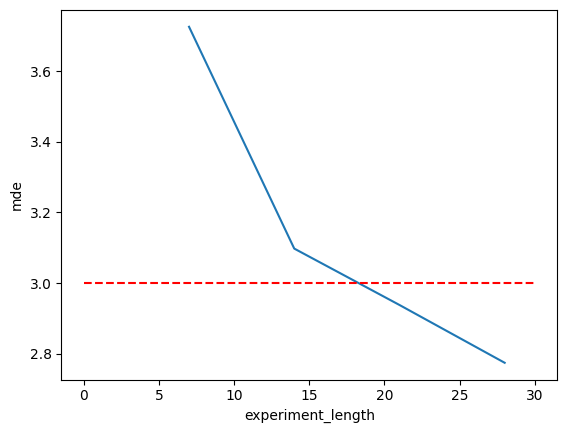

In [6]:
mde_value = 3
plot_mdes(mdes, y_value=mde_value, x_lim=30)

In [7]:
get_length_print(mdes, mde_value)

Minimum experiment length to detect MDE of 3: 21


The age of the customer is a good predictor of the orde value that is not impacted by the treatment. We can use this covariate to adjust our analysis and decrease mde. We see that mde is smaller in this case, because we are using a covariate that is not impacted by the treatment.

In [8]:
mde_variance_reduction = NormalPowerAnalysis.from_dict({
    "splitter": "clustered",
    "analysis": "clustered_ols",
    "time_col": "date",
    "target_col": "order_value",
    "cluster_cols": ["customer_id"],
    "covariates": ["customer_age"]
})

In [9]:
mdes = mde_variance_reduction.mde_time_line(
    experiment_data,
    powers=[0.8],
    experiment_length=(1, 4, 7, 14, 21, 28, 35, 42),
    n_simulations=5
)

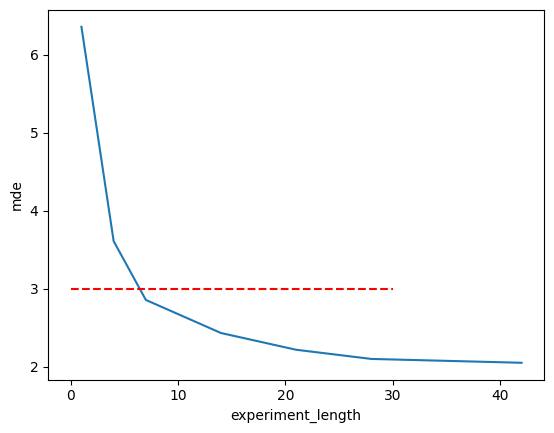

In [10]:
plot_mdes(mdes, y_value=mde_value, x_lim=30)

In [11]:
get_length_print(mdes, mde_value)

Minimum experiment length to detect MDE of 3: 7


This is the last example of power analysis.

We assume data from Feb onwards is used to run the power analysis (it's the data we take as experimental, though it is actually pre-experimental data). Data from Jan is taken as pre-experimental data. We simulate that the experiment happened after Feb. We do this because we need pre-experimental data to train the Cupac Model, which we didn't do before.

We use cupac model with customer id and age features (order value has a non-linear relationship with customer id, that's why we don't add it a single covariate). We use the same data as before, but we train the model with pre-experimental data. We see that mde is smaller in this case, because we are using a **better** covariate that is not impacted by the treatment.

In this case we cannot init by dict because we're using cupac, but happy to review a PR that includes this :) In this case we need to create splitter and analysis classes.

In [12]:
pre_experiment_df = experiment_data.query("date < '2024-02-01'")
experiment_df = experiment_data.query("date >= '2024-02-01'")

In [13]:
from cluster_experiments import ClusteredSplitter, ClusteredOLSAnalysis
from sklearn.ensemble import HistGradientBoostingRegressor


splitter = ClusteredSplitter(
    cluster_cols=["customer_id"],
)
ols = ClusteredOLSAnalysis(
    target_col="order_value",
    covariates=["estimate_order_value"],
    cluster_cols=["customer_id"],
)

pwr = NormalPowerAnalysis(
    splitter=splitter,
    analysis=ols,
    cupac_model=HistGradientBoostingRegressor(),
    time_col="date",
    target_col="order_value",
    features_cupac_model=["customer_id", "customer_age"],
)


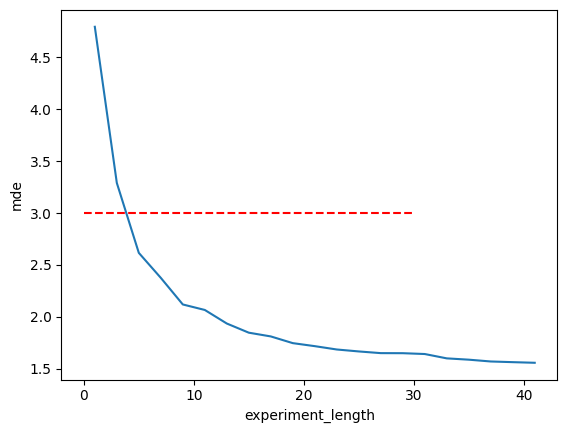

In [14]:
mde_cupac = pwr.mde_time_line(
    experiment_df,
    pre_experiment_df,
    powers=[0.8],
    experiment_length=range(1, 42, 2),
    n_simulations=5,
)

plot_mdes(mde_cupac, y_value=mde_value, x_lim=30)

In [15]:
get_length_print(mde_cupac, mde_value)

Minimum experiment length to detect MDE of 3: 5


## Analysis

Now we run analysis assuming that the experiment run after 2024-03-01 for 3 weeks. We simulate some fake effects (1.5 in order value and 0.2 in delivery time). We use functionalities in cluster_experiments to simulate the experiment.

In [16]:
real_experiment_data = experiment_data.query("date >= '2024-03-01' and date < '2024-03-21'")
real_pre_experiment_data = experiment_data.query("date < '2024-03-01'")
real_experiment_data

from cluster_experiments import ClusteredSplitter, ConstantPerturbator


# Add effect on the order value
splitter = ClusteredSplitter(
    cluster_cols=["customer_id"],
)
perturbator = ConstantPerturbator(
    target_col="order_value",
)

real_experiment_data = splitter.assign_treatment_df(real_experiment_data)
real_experiment_data = perturbator.perturbate(real_experiment_data, average_effect=1.5)

# Add effect on the delivery time
perturbator = ConstantPerturbator(
    target_col="delivery_time",
)
real_experiment_data = perturbator.perturbate(real_experiment_data, average_effect=.2)
real_experiment_data

,customer_id,customer_age,order_value,delivery_time,city,date,treatment
0,831,23,65.235192,8.933512,NYC,2024-03-17,A
1,561,58,92.654383,7.176415,LA,2024-03-20,B
2,391,31,101.486430,9.643470,LA,2024-03-16,B
3,277,57,91.538628,8.410730,LA,2024-03-12,B
4,884,30,94.140176,9.091150,NYC,2024-03-20,B
...,...,...,...,...,...,...,...
2159,13,59,91.067824,7.331142,NYC,2024-03-01,A
2160,299,43,91.388094,6.401728,NYC,2024-03-05,A
2161,787,36,81.456158,7.185609,NYC,2024-03-15,A
2162,149,44,82.405384,8.764580,LA,2024-03-20,B


We run the analysis with and without covariate adjustment. We use city as a dimension, showing results in the overall population and by city. 

We see that the effect is larger when we use covariate adjustment, because we are using a better covariate that is not impacted by the treatment. We also show how to calculate the MDE for a given power and effect size.

In [17]:
from cluster_experiments import AnalysisPlan, HypothesisTest, Variant, SimpleMetric

plan = AnalysisPlan.from_metrics_dict({
    "metrics": [
        {"alias": "AOV", "name": "order_value"},
        {"alias": "delivery_time", "name": "delivery_time"},
    ],
    "variants": [
        {"name": "A", "is_control": True},
        {"name": "B", "is_control": False},
    ],
    "variant_col": "treatment",
    "alpha": 0.05,
    "dimensions": [
        {"name": "city", "values": ["NYC", "LA"]},
    ],
    "analysis_type": "clustered_ols",
    "analysis_config": {"cluster_cols": ["customer_id"]},
})


We see that CIs contain the true effect, and CIs are pretty big.

In [18]:
# Run the analysis plan
plan.analyze(real_experiment_data).to_dataframe()

,metric_alias,control_variant_name,treatment_variant_name,control_variant_mean,treatment_variant_mean,analysis_type,ate,ate_ci_lower,ate_ci_upper,p_value,std_error,dimension_name,dimension_value,alpha
0,AOV,A,B,81.929798,84.346509,clustered_ols,2.416712,0.315398,4.518025,0.024187,1.072118,__total_dimension,total,0.05
1,AOV,A,B,81.778970,84.030982,clustered_ols,2.252012,-0.147058,4.651082,0.065794,1.224038,city,NYC,0.05
2,AOV,A,B,82.068329,84.653585,clustered_ols,2.585256,0.198567,4.971944,0.033751,1.217721,city,LA,0.05
3,delivery_time,A,B,8.012237,8.182237,clustered_ols,0.169999,0.057150,0.282849,0.003152,0.057578,__total_dimension,total,0.05
4,delivery_time,A,B,7.995034,8.140337,clustered_ols,0.145303,0.012721,0.277885,0.031712,0.067645,city,NYC,0.05
5,delivery_time,A,B,8.028038,8.223014,clustered_ols,0.194976,0.060193,0.329759,0.004579,0.068768,city,LA,0.05


Now we use covariate adjustment with customer age. We see that the effect in order value is closer to the true effect, but the effect in delivery time is just as bad. This is because in our data generation process we used customer age as a covariate for order value but not for delivery time.

In [19]:
plan_covariates = AnalysisPlan.from_metrics_dict({
    "metrics": [
        {"alias": "AOV", "name": "order_value"},
        {"alias": "delivery_time", "name": "delivery_time"},
    ],
    "variants": [
        {"name": "A", "is_control": True},
        {"name": "B", "is_control": False},
    ],
    "variant_col": "treatment",
    "alpha": 0.05,
    "dimensions": [
        {"name": "city", "values": ["NYC", "LA"]},
    ],
    "analysis_type": "clustered_ols",
    "analysis_config": {
        "cluster_cols": ["customer_id"],
        "covariates": ["customer_age"],
    },
})

In [20]:
# Run the analysis plan
plan_covariates.analyze(real_experiment_data).to_dataframe()

,metric_alias,control_variant_name,treatment_variant_name,control_variant_mean,treatment_variant_mean,analysis_type,ate,ate_ci_lower,ate_ci_upper,p_value,std_error,dimension_name,dimension_value,alpha
0,AOV,A,B,81.929798,84.346509,clustered_ols,2.588424,0.945550,4.231298,0.002015,0.838216,__total_dimension,total,0.05
1,AOV,A,B,81.778970,84.030982,clustered_ols,2.112448,0.248134,3.976762,0.026363,0.951198,city,NYC,0.05
2,AOV,A,B,82.068329,84.653585,clustered_ols,3.058242,1.166815,4.949668,0.001529,0.965031,city,LA,0.05
3,delivery_time,A,B,8.012237,8.182237,clustered_ols,0.169061,0.056424,0.281697,0.003263,0.057469,__total_dimension,total,0.05
4,delivery_time,A,B,7.995034,8.140337,clustered_ols,0.146025,0.014186,0.277864,0.029942,0.067266,city,NYC,0.05
5,delivery_time,A,B,8.028038,8.223014,clustered_ols,0.192335,0.057672,0.326997,0.005120,0.068706,city,LA,0.05


Now we run analysis using cupac model. We see that the effect in both metrics is closer to the true effect, and the CIs are smaller.

In [21]:
plan_cupac = AnalysisPlan(
    tests=[
        HypothesisTest(
            metric=SimpleMetric(alias="AOV", name="order_value"),
            analysis_type="clustered_ols",
            analysis_config={
                "cluster_cols": ["customer_id"],
                "covariates": ["customer_age", "estimate_order_value"],
            },
            cupac_config={
                "cupac_model": HistGradientBoostingRegressor(),
                "features_cupac_model": ["customer_id", "customer_age"],
                "target_col": "order_value",
            },
        ),
        HypothesisTest(
            metric=SimpleMetric(alias="delivery_time", name="delivery_time"),
            analysis_type="clustered_ols",
            analysis_config={
                "cluster_cols": ["customer_id"],
                "covariates": ["customer_age", "estimate_delivery_time"],
            },
            cupac_config={
                "cupac_model": HistGradientBoostingRegressor(),
                "features_cupac_model": ["customer_id", "customer_age"],
                "target_col": "delivery_time",
            },
        ),
    ],
    variants=[
        Variant(name="A", is_control=True),
        Variant(name="B", is_control=False),
    ],
    variant_col="treatment",
)

In [22]:
plan_cupac.analyze(
    real_experiment_data,
    real_pre_experiment_data,
).to_dataframe()

,metric_alias,control_variant_name,treatment_variant_name,control_variant_mean,treatment_variant_mean,analysis_type,ate,ate_ci_lower,ate_ci_upper,p_value,std_error,dimension_name,dimension_value,alpha
0,AOV,A,B,81.929798,84.346509,clustered_ols,1.803072,0.678043,2.928101,1.682500e-03,0.574005,__total_dimension,total,0.05
1,delivery_time,A,B,8.012237,8.182237,clustered_ols,0.195599,0.150556,0.240643,1.723474e-17,0.022982,__total_dimension,total,0.05
